# COMS 4733 Computational Aspects of Robotics -- Homework 3

In this homework, we will go over the perception workflow of a robotic system: from camera calibration, to point cloud construction, segmentation, and semantic feature queries.

**What's covered**

- Pinhole camera model
- Camera calibration
- 3D coordinate transformation
- RGB, depth, and robot trajectory data processing
- Point cloud visualization
- Segmentation mask processing
- DINO feature extraction and similarity calculation

**Data**

Data can be downloaded from [Google Drive](https://drive.google.com/file/d/1QwiaJQWEGN_Kmvs_bOmcBlbauv8R7N2M/view?usp=sharing) (LionMail required for viewing), and should be extracted under the same directory as the .ipynb file. The extracted data structure should look like:
- parent directory/
  - COMS4733_HW3.ipynb
  - data/
    - calibration/
    - recording/
    - vis/

**Submission**

Submit a ```.zip``` file containing the following:
- The notebook file (```.ipynb```) with completed codes and the outputs of the code blocks.
- A ```.pdf``` report, containing answers to the written questions. All written questions can be found in the text instructions of each problem.

**Discussion policy**

You may discuss high-level ideas with classmates,
but your answers must be your own. Cite all external sources. List collaborators
(names/UNIs) at the end of the PDF report.

**Accessibility and extensions**

For documented accommodations or emergencies, contact the instructor/TA prior to the deadline when possible.

## 0. Notebook Setup

We recommend running the code in your local environment. If you use a local environment, we recommend using [miniconda](https://www.anaconda.com/docs/getting-started/miniconda/main) or [uv](https://docs.astral.sh/uv/) for python environment management. Most packages can be installed via pip. 

**Special requirements**
- For pytorch, please refer to the [official website](https://pytorch.org/get-started/locally/) for installation commands.
- **important**: Install ```cv2``` via ```pip install opencv-contrib-python==4.12.0```. ```opencv-contrib-python``` and ```opencv-python``` are similar packages and share the name ```cv2```. However, only ```opencv-contrib-python``` contains the aruco marker detection functions. If you have ```opencv-python``` previously installed, please uninstall first.
- ```open3d==0.19.0``` is recommended for better integration with jupyter notebook. When running open3d visualizations, i.e. ```o3d.visualization.visualize_geometries``` and ```o3d.visualization.Visualizer()```, GUI display will pop up.
- If you have difficulties accessing the data, do not have a local GUI machine, or do not have enough CPU/RAM for the code, please report to the TAs.

GPU is **not required** for this assignment.

After you successfully set up your environment, run the following code to test that all packages can be imported correctly:

In [1]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import transforms3d
import torch
from torch.nn.functional import interpolate
import time
import glob

## 1. Camera Calibration (15 pts)

### 1.1 Constructing the Intrinsic Matrix (5 pts)

In this section, you will construct the 3x3 **camera intrinsics matrix** \( K \) using the given the camera parameters.

You are provided with:
- **Focal lengths** \( f_x, f_y \) (in pixels)
- **Principal point** coordinates \( c_x, c_y \)

**Instructions:** 
1. Implement the missing code. (3 pts)
2. In the report, answer the following question: suppose we have an image of size H x W. For computational reasons, we want to downsample the image by half, i.e. if image is a numpy array with size (H, W, 3), we apply ```image = image[::2, ::2, :]```, resulting in a (H/2, W/2, 3) array. Now suppose the H x W image was originally captured by a pinhole camera with parameters ```fx, fy, px, py```. If we want to change the camera parameters, such that the captured image is directly the same with the downsampled H/2 x W/2 image ignoring differences within 1 pixel), how should we set the new ```fx, fy, cx, cy``` parameters? (2 pts)

In [2]:
def get_camera_intrinsics(fx: float, fy: float, cx: float, cy: float) -> np.ndarray:
    # return: 3x3 camera intrinsics matrix K

    ### TODO YOUR CODE STARTS ###
    K = None
    ### TODO YOUR CODE ENDS ###

    return K

### 1.2 Charuco board detection (10 pts)

Below we load the 4 camera images from `data/calibration/` and run Charuco/marker detection using OpenCV.
We display an overlay for each camera showing detected markers and Charuco corners.

**Charuco board**

We use charuco board for calibration. Charuco is a combination of Checkerboard and Aruco. A simple introduction is [here](https://docs.opencv.org/3.4/df/d4a/tutorial_charuco_detection.html). Below is a script that visualizes of the board.

[ WARN:0@46.395] global loadsave.cpp:275 findDecoder imread_('data/vis/charuco.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.12.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


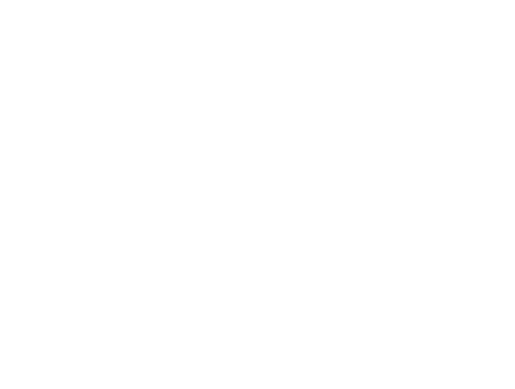

In [3]:
board_image = cv2.imread('data/vis/charuco.jpg')
plt.axis('off')
plt.imshow(cv2.cvtColor(board_image, cv2.COLOR_BGR2RGB))
plt.show()

The detection of charuco board is done by opencv. We use its python version. The opencv-python package (can be simply used by ```import cv2```) has a few predefined utilities we can use. For example, ```cv2.aruco.CharucoBoard``` defines the board parameters by taking in the size of the board (6x5 in our case), the edge length of the checkerboard (0.04m in our case), and the edge length of each aruco marker (0.03m in our case). Run the following code block to load the parameters and other utilities.

In [ ]:
# we first define the charuco board
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)
charuco_board = cv2.aruco.CharucoBoard((6, 5), 0.04, 0.03, aruco_dict)
charuco_params = cv2.aruco.CharucoParameters()
charuco_detector = cv2.aruco.CharucoDetector(charuco_board, charuco_params)

**Calibration function**

Here we directly give the opencv function that takes in the image, detects charuco markers and visualize them, and finally returns ```rvec``` and ```tvec```, which represents the world-to-camera rotation and translation, represented in a 3-dimensional rotation vector and 3-dimensional translation vector.

In [ ]:
def calibrate(img_path, K):
    # read image
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # detect charuco board
    charuco_corners, charuco_ids, marker_corners, marker_ids = charuco_detector.detectBoard(gray)

    vis = img.copy()
    cv2.aruco.drawDetectedMarkers(vis, marker_corners, marker_ids)
    plt.figure(figsize=(6, 4), dpi=150)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(f'Detected markers')
    plt.axis('off')
    plt.show()

    # estimate pose
    retval, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(
        charuco_corners,
        charuco_ids,
        charuco_board,
        cameraMatrix=K,
        distCoeffs=np.zeros(5, dtype=np.float32),
        rvec=None,  # placeholder
        tvec=None,  # placeholder
    )

    # Visualize pose on the image
    vis = img.copy()
    cv2.drawFrameAxes(vis, K, np.zeros(5, dtype=np.float32), rvec, tvec, 0.1)
    plt.figure(figsize=(6, 4), dpi=150)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(f"Pose Visualization")
    plt.axis('off')
    plt.show()

    return rvec, tvec

Using the given functions, we can now estimate the world-to-camera transformations. Hint: ```cv2.Rodrigues``` is a useful function in converting 3D rotation vectors to the commonly-used 3x3 rotation matrix. Usage: ```rotation_matrix, _ = cv2.Rodrigues(rvec)```

**Instructions:** 
1. Implement the missing code. (7 pts)
2. In the report, answer the question: in the world frame, which axis is parallel to the vertical direction (orthogonal to the table surface)? On that axis, is the camera center's position positive or negative? (3 pts)

In [ ]:
names = ['front', 'wrist']
img_paths = ['./data/calibration/camera_front.png', './data/calibration/camera_wrist.png']

# to store extrinsic matrices
extrinsics = {}

# read intrinsics file
with open('data/calibration/intrinsics.json', 'r') as f:
    intrinsics = json.load(f)

for name, img_path in zip(names, img_paths):
    # compute the calibration and get camera extrinsics

    ### TODO YOUR CODE STARTS ###
    world_T_camera = None
    ### TODO YOUR CODE ENDS ###

    extrinsics[name] = world_T_camera.tolist()

# save to file
with open('data/calibration/extrinsics_result.json', 'w') as f:
    json.dump(extrinsics, f, indent=2)

If you called the ```calibrate``` function correctly, you will be able to see the following visualizations (by running the script below; resolution may be different). For each camera view, the first visualization shows all the individual aruco markers detected (you can see green bounding boxes and blue texts displaying their ids); the second visualization shows the coordinate frame, located at one corner of the charuco board, and with red, green, and blue axes pointing towards the x, y, z directions of the world frame.

In [ ]:
board_image = cv2.imread('data/vis/calibration_result_1.png')
plt.axis('off')
plt.imshow(cv2.cvtColor(board_image, cv2.COLOR_BGR2RGB))
plt.show()
board_image = cv2.imread('data/vis/calibration_result_2.png')
plt.axis('off')
plt.imshow(cv2.cvtColor(board_image, cv2.COLOR_BGR2RGB))
plt.show()
board_image = cv2.imread('data/vis/calibration_result_3.png')
plt.axis('off')
plt.imshow(cv2.cvtColor(board_image, cv2.COLOR_BGR2RGB))
plt.show()
board_image = cv2.imread('data/vis/calibration_result_4.png')
plt.axis('off')
plt.imshow(cv2.cvtColor(board_image, cv2.COLOR_BGR2RGB))
plt.show()

If you calculated correctly, the saved extrinsics file ```data/calibration/extrinsics_result.json``` should be identical with ```data/calibration/extrinsics.json```. Note that we will check your code implementation for grading, but not the resulting file, so simply copying the file will not count.

## 2. Point Cloud Visualization (45 pts)

### 2.1 Inverse projection function (10 pts)

Given the depth image and the intrinsics, how to recover the point cloud? This is equivalent to the inverse operation of the camera space to image plane projection, which we call "inverse projection". 

**Instructions**
- Complete the inverse projection function. You may or may not use the provided ```x, y``` arrays generated using the ```np.meshgrid``` function. (7 pts)
- In the report, write (as formulas) or briefly explain (in sentences) the mathmatical formulation of the inverse projection function. (3 pts)

In [ ]:
def depth_to_camera_frame_point_cloud(depth, K):
    # depth: HxW depth image
    # K: 3x3 camera intrinsics matrix
    # return: Nx3 point cloud in the camera frame
    H, W = depth.shape
    x, y = np.meshgrid(np.arange(W), np.arange(H))

    ### TODO YOUR CODE STARTS ###
    points = None
    ### TODO YOUR CODE ENDS ###

    return points

### 2.2 Camera to world transformation function (10 pts)

After we get the point clouds in the camera frame using the function in 2.1, we want to transform the points from the camera frame to the world frame (defined by the calibration charuco board). Suppose we are given the points and the extrinsic matrix, the function needs to perform the transformation and return the points in the world frame.

**Instructions**
- Complete the code. (7 pts)
- In the report, write (as formulas) or briefly explain (in sentences) the mathmatical formulation of the transformation function. (3 pts)

In [ ]:
def transform_camera_to_world(points, extrinsic_matrix):
    # points: Nx3 point cloud in the camera frame
    # extrinsic_matrix: 4x4 camera-to-world extrinsic matrix
    # return: Nx3 point cloud in the world frame

    ### TODO YOUR CODE STARTS ###
    pts = None
    ### TODO YOUR CODE ENDS ###

    return pts

### 2.3. Robot motions and wrist camera extrinsics (15 pts)

When we merge the point clouds from the fixed cameras and wrist cameras, one problem remains: the wrist camera is mounted to the robot. It keeps relatively static to the robot's end effector (eef), rather than the calibration board. Therefore, as the robot moves, the extrinsics (world-to-camera) matrix for the wrist camera will change. In this sub-problem, we will complete the functions for calculating the new wrist camera extrinsics.

**Robot trajectores**

We save the robot trajectories in the ```data/recordings/robot``` directory. The following function reads the robot end effector's cartesian positions and orientations relative to the robot base, and returns the transformation matrix from the robot end effector to the robot base, given a frame index. The function is directly given.

In [ ]:
def read_eef_T_base(frame_idx):
    with open(f'data/recording/robot/{frame_idx:06d}.json') as f:
        data = json.load(f)
    new_ee_pos = np.array(data['obs.ee_pos'])
    new_ee_quat = np.array(data['obs.ee_quat'])
    new_ee_rot = transforms3d.quaternions.quat2mat(new_ee_quat)
    eef_T_base = np.eye(4)
    eef_T_base[:3, :3] = new_ee_rot
    eef_T_base[:3, 3] = new_ee_pos
    return eef_T_base

Now that we have the function to read the end effector motions, in the following function, we will calculate the wrist camera extrinsics (```world_to_new_wristcam```) given the old wrist camera extrinsics (```world_to_old_wristcam```) and the new robot pose (```new_eef_T_base```). To do this, we also need the old robot pose (```old_eef_T_base```) (i.e., the robot pose when the wrist camera calibration is done) and the robot base to calibration board transformation (```base_T_world```). These two transformations are constant, and we already hardcoded them into the function

**Instructions**
- Complete the function. (10 pts)
- In the report, write the mathmatical formulations for claculating the new wristcam extrinsics. (5 pts)

In [ ]:
def calculate_wristcam_extrinsics(world_T_old_wristcam, new_eef_T_base):
    # world_T_old_wristcam: 4x4 old wrist camera extrinsics
    # new_eef_T_base: 4x4 new end effector to robot base transformation
    # return: 4x4 new wrist camera extrinsics

    # these are hardcoded constants
    old_eef_T_base = np.array([
        [1.0, 0.0, 0.0, 0.2568],
        [0.0, -1.0, 0.0, 0.0],
        [0.0, 0.0, -1.0, 0.4005],
        [0.0, 0.0, 0.0, 1.0],
    ])
    base_T_world = np.array(
        [[1.0, 0.0, 0.0, -0.185],
         [0.0, -1.0, 0.0, 0.115],
         [0.0, 0.0, -1.0, -0.01],
         [0.0, 0.0, 0.0, 1.0]]
    )

    ### TODO YOUR CODE STARTS ###
    world_to_new_wristcam = None
    ### TODO YOUR CODE ENDS ###

    return world_to_new_wristcam

### 2.4 Visualize (10 pts)

Finally, we are ready to visualize the point clouds! We will use the recording data from the ```data/recordings/``` dir. The code will show the two rgb and depth images at frame 0, and launch an open3d interactive visualization of the merged point cloud. Feel free to play around with other frames as well.

**Instructions**
- Write the function calls to the previously defined functions. (7 pts) Note that 
  - The desired output from your code block is the N x 3 ```pts``` array (in world frame) and ```colors``` array (rgb values are already normalized to 0.0-1.0, and you do not need to further modify that).
  - You might need to apply different extrinsics calculation for wrist camera (```name == 'wrist'```) and front camera (```name == 'front'```).
- In the report, include a **screenshot** of the open3d point cloud visualization, and **answer** the question: from your final results, how can we visually verify that the calculated wrist camera extrinsics is correct? (E.g., what are some visual cues in the open3d visualization?) (3 pts)

In [ ]:

def construct_merged_point_cloud(frame_idx, visualize=True):
    names = ['front', 'wrist']

    # load intrinsics and extrinsics
    with open('data/calibration/intrinsics.json', 'r') as f:
        intrinsics = json.load(f)
    with open('data/calibration/extrinsics.json', 'r') as f:
        extrinsics = json.load(f)

    # to store the merged point cloud
    pts_all = []
    color_all = []

    # iterate through each camera
    for name in names:
        rgb_path = f'./data/recording/camera_{name}/rgb/{frame_idx:06d}.jpg'
        depth_path = f'./data/recording/camera_{name}/depth/{frame_idx:06d}.png'

        # visualize first frame
        color = cv2.imread(rgb_path)
        color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
        color = color.astype(np.float32) / 255.0

        # visualize color image
        if visualize:
            plt.figure(figsize=(6, 4), dpi=150)
            plt.imshow(color)
            plt.axis('off')
            plt.show()

        # read depth image
        if name == 'front':
            depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED) / 1000.0  # mm to m
        if name == 'wrist':
            depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED) / 10000.0  # 0.1mm to m

        # visualize depth image
        if visualize:
            depth_vis = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            depth_vis = cv2.applyColorMap(depth_vis, cv2.COLORMAP_VIRIDIS)
            depth_vis = cv2.cvtColor(depth_vis, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(6, 4), dpi=150)
            plt.imshow(depth_vis)
            plt.axis('off')
            plt.show()

        # convert depth and rgb images to point cloud (pts and colors)
        ### TODO YOUR CODE STARTS ###
        pts = None
        color = None
        ### TODO YOUR CODE ENDS ###

        # filter points within bounding box for better visual quality
        bbox = np.array([[-0.5, -0.5, -1.0], [0.8, 0.5, 0.2]])
        pts_mask = np.logical_and.reduce((
            pts[:, 0] >= bbox[0, 0], pts[:, 0] <= bbox[1, 0],
            pts[:, 1] >= bbox[0, 1], pts[:, 1] <= bbox[1, 1],
            pts[:, 2] >= bbox[0, 2], pts[:, 2] <= bbox[1, 2]
        ))
        pts = pts[pts_mask]
        color = color[pts_mask]

        pts_all.append(pts)
        color_all.append(color)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.ascontiguousarray(np.concatenate(pts_all, axis=0)).astype(np.float64))
    pcd.colors = o3d.utility.Vector3dVector(np.ascontiguousarray(np.concatenate(color_all, axis=0)).astype(np.float64))
    if visualize:
        o3d.visualization.draw_geometries([pcd])
    return pcd


_ = construct_merged_point_cloud(frame_idx=0, visualize=True)

Here, we also provide an interesting dynamic video visualization of the point cloud. We reconstruct the point cloud for each frame and play the resulting point cloud sequence in real time using the open3d visualizer. You can see the entire process of the robot hanging the green mug on the rack, from the front camera view. Try the code! You can also change to the wrist camera view (how?), or implement any camera motions you like. You can include interesting results in the report, but it is not required and will not be graded.

Note that the point cloud reconstruction could take a while.

The desired visualization should look like:

![image](data/vis/seq.png)

In [ ]:
def video_visualization(geoms):
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(geoms[0])

    ctr = vis.get_view_control()
    params = ctr.convert_to_pinhole_camera_parameters()
    with open('data/calibration/extrinsics.json', 'r') as f:
        extrinsics = json.load(f)
    E = np.array(extrinsics['front'], dtype=float)
    params.extrinsic = E
    ctr.convert_from_pinhole_camera_parameters(params, allow_arbitrary=True)

    vis.poll_events()
    vis.update_renderer()
    
    for g in geoms[1:]:
        vis.clear_geometries()
        vis.add_geometry(g)
        ctr.convert_from_pinhole_camera_parameters(params, allow_arbitrary=True)
        vis.poll_events()
        vis.update_renderer()
        time.sleep(0.03)
    vis.destroy_window()

pts_all_list = []
for frame_idx in range(371):
    print(f"Processing frame {frame_idx}")
    pcd = construct_merged_point_cloud(frame_idx, visualize=False)
    pts_all_list.append(pcd)

video_visualization(pts_all_list)

## 3. Semantic Segmentation (24 pts)
### 3.1 Visualize the Segmentation of Pens (17 pts)
We provide four masks corresponding to the pens visible in the image. Please refer to the code in Section 3.2 to: (12 pts)
1.	Project the front-view RGB and depth images into a point cloud (PCD).
2.	Load all four pen masks.
3.	Mask the corresponding points, assign a distinct color to each pen, and visualize all of them.

For the report, please include all intermediate visualizations along with descriptions of your implementation steps and any challenges you encountered during the process. (5 pts)

The expected final visualization is shown below:

![image.png](data/vis/example_output.png)

In [ ]:
# Load RGB & Depth & 4 Masks
name = "front"
rgb_path = './data/recording/camera_front/rgb/000000.jpg'
depth_path = './data/recording/camera_front/depth/000000.png'
mask_paths = './data/vis/masks'

### TODO Write your code here


### 3.2 Geometric Distance Calculation (7 pts)

After obtaining separate point clouds for each pen, assume each pen’s location is represented by the centroid of its point cloud. Please compute the closest and farthest pairwise distances among the pens. Additionally, clearly state which two pens (by color) are the closest and which two are the farthest apart. (5 pts)

For the report, please include all intermediate calculation results and provide a description of what each calculation represents. (2 pts)

In [ ]:
### TODO Write your code here


## 4. Semantic Features (16 pts)

In this section, you will learn how to extract DINO-V2 features from an image and write code to visualize a heatmap of feature similarity for a given query pixel. (12 pts)

In your report, please include the visualizations, explain the final heatmap, and discuss your observations and findings. Additionally, select two more query points, generate their visualizations, and provide discussions on your findings for these points as well. (4 pts)


In [ ]:
rgb_path = './data/recording/camera_front/rgb/000000.jpg'
rgb = cv2.imread(rgb_path)

dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').eval()

# Hyperparameters
patch_size = 14

# ensure input shape is compatible with dinov2
H, W, _ = rgb.shape
patch_h = int(H // patch_size)
patch_w = int(W // patch_size)
new_H = patch_h * patch_size
new_W = patch_w * patch_size
transformed_rgb = cv2.resize(rgb, (new_W, new_H))
transformed_rgb = transformed_rgb.astype(np.float32) / 255.0 
img_tensors = torch.tensor(transformed_rgb, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

# Use DINOv2 to extract pixel-wise features
features_dict = dinov2.forward_features(img_tensors)
raw_feature_grid = features_dict['x_norm_patchtokens']  # float32 [num_cams, patch_h*patch_w, feature_dim]
raw_feature_grid = raw_feature_grid.reshape(1, patch_h, patch_w, -1)  # float32 [num_cams, patch_h, patch_w, feature_dim]

# compute per-point feature using bilinear interpolation
DINO_feature = interpolate(raw_feature_grid.permute(0, 3, 1, 2),  # float32 [num_cams, feature_dim, patch_h, patch_w]
                                        size=(H, W),
                                        mode='bilinear').permute(0, 2, 3, 1).squeeze(0)  # float32 [H, W, feature_dim]

print(DINO_feature.shape)  # should be [H*W, feature_dim]
print(rgb.shape)

# Select a point on the image
x, y = 470, 268 # Query Point
plt.figure(figsize=(6, 4), dpi=150)
plt.imshow(cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB))
plt.scatter([y], [x], c='r', s=50)
plt.title(f"Query Point ({x}, {y})")

query_feature = np.array(DINO_feature[x, y, :].tolist(), dtype=np.float32)  # float32 [feature_dim]

# Draw the heatmap figure to based on the cosine similarity
### TODO Write your code here



## Submission checklist
Include all the problems in your PDF report, and keep all the outputs of the notebook. A list of the question indices are:

```1.1, 1.2```

```2.1, 2.2, 2.3, 2.4```

```3.1, 3.2```

```4```
